In [1]:
!nvidia-smi

Thu Mar  7 00:31:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import the helper functions and import the other functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-07 00:31:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-07 00:31:00 (82.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
import tensorflow as tf

### Get the data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-03-07 00:31:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 142.250.136.207, 142.250.148.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   111MB/s    in 1.4s    

2024-03-07 00:31:09 (111 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Steps for modelling experimentation
1. Experiment - Model 0
2. Data - random 10% of training data
3. Preprocessing : None
4. Model - feature extractor(EfficientNetB0)

## Model 0: Building a transfer learning model using a the keras functional API
### For feature engineering, we are changing the top layer
### The EfficientNetB0-7 -> means increasing complexities from 0 to 7
### Normalising is required when using Resnet50V2(efficientnet has rescaling features built in)



In [9]:
 #1.Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model(so the underlying pretrained models aren't updated )
base_model.trainable=False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

#4. If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model.
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after global average pooling 2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#10. Fit the model and save history
hostory_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data_10_percent,
                               validation_steps=int(0.25*len(test_data_10_percent)),
                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                      experiment_name='10_percent_feature_extraction')])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240307-003122
Epoch 1/5
24/24 [==============================] - 16s 261ms/step - loss: 1.8666 - accuracy: 0.4360 - val_loss: 1.3148 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 4s 132ms/step - loss: 1.1047 - accuracy: 0.7480 - val_loss: 0.8912 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 5s 176ms/step - loss: 0.7978 - accuracy: 0.8240 - val_loss: 0.7299 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - 4s 172ms/step - loss: 0.6441 - accuracy: 0.8640 - val_loss: 0.6282 - val_accuracy: 0.8421
Epoch 5/5
24/24 [==============================] - 4s 172ms/step - loss: 0.5493 - accuracy: 0.8733 - val_loss: 0.5683 - val_accuracy: 0.8487


In [10]:
# Evaluate on the full test data
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 76ms/step - loss: 0.5601 - accuracy: 0.8604


[0.5600999593734741, 0.8604000210762024]

In [11]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

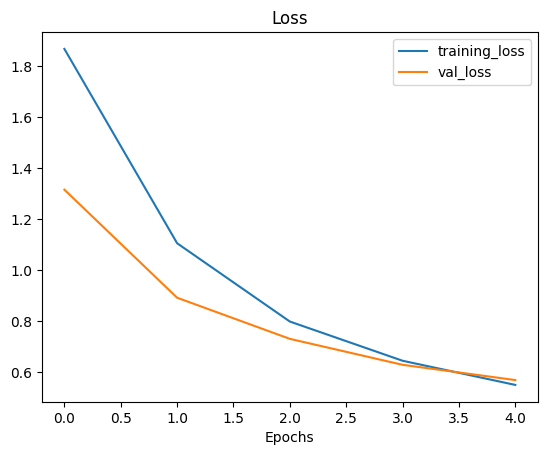

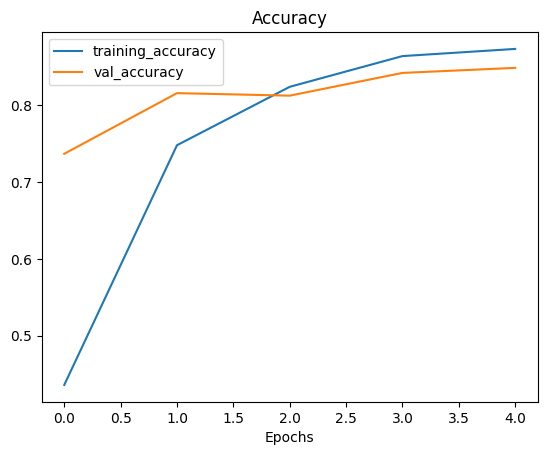

In [12]:
#Check out the model's training curves
plot_loss_curves(hostory_10_percent)

## Getting a feature vector from a trained model

In [13]:
input_shape=(1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [14]:
# lets replicate the globalaveragepool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Running a series of transfer learning experiments.
We have seen the results with 10% of the training data. Lets check the same with 1% data.
1. model_1 - Use feature extraction along with data augmentation(for 1% training data).
2. model_2 - Use feature extraction along with data augmnetation(for 10% of training data).
3. model_3 - Use fine tuning transfer learning along with data augmentation(with 10% of training data)
4. model_4 - use fine tuning along with data augmentation for 100% of training data.

In [15]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-03-07 00:32:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.207, 142.250.159.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   116MB/s    in 1.1s    

2024-03-07 00:32:18 (116 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [17]:
#Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
- To add data augmentation we need to add preprocessing layers inside.

- The Image Data Generator performs augmentation on a CPU, whereas the preprocessing layers does it on the GPU.

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zoom, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) #keep for models like ResNet50 but models like EfficientNetV2 has rescaling built in.
],name='data_augmentation')

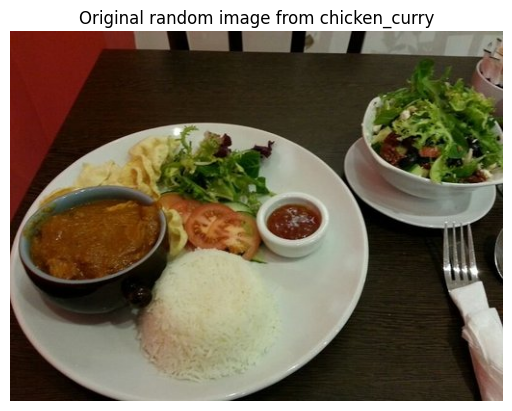

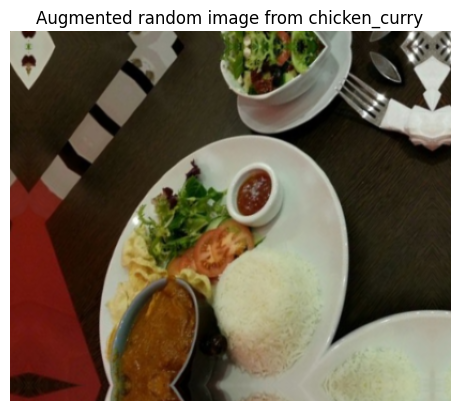

In [19]:
# Visualize our data augmentation layer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" +random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from {target_class}")
plt.axis(False);

In [20]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feature extraction transfer learning on 1% of data with data augmentation.

In [21]:
#Setup input shape and base model, and freezing the base model layers
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create input layer
inputs = layers.Input(shape=input_shape,name='input_layer')

#Add the data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model the inputs(after augmentation) but dont train it
x = base_model(x, training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='Global_average_pooling_layer')(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

#Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240307-003224
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.3723 - accuracy: 0.1429 - val_loss: 2.2460 - val_accuracy: 0.1809
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.1313 - accuracy: 0.2286 - val_loss: 2.1239 - val_accuracy: 0.2500
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9693 - accuracy: 0.2714 - val_loss: 2.0205 - val_accuracy: 0.3026
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.7193 - accuracy: 0.5714 - val_loss: 1.9010 - val_accuracy: 0.4095
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5883 - accuracy: 0.5857 - val_loss: 1.8213 - val_accuracy: 0.4507


In [22]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [23]:
#Evaluate on the full test data
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 1.8048 - accuracy: 0.4664


[1.8048220872879028, 0.46639999747276306]

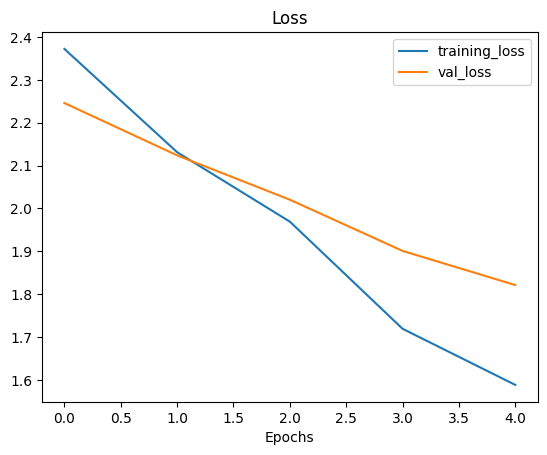

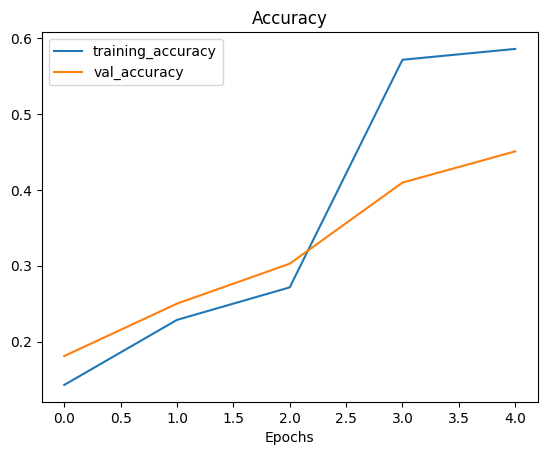

In [24]:
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation.

In [25]:
#Get 10% of data
import tensorflow as tf
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [26]:
#Set data inputs
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                      label_mode='categorical',
                                                      image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
#Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentaion')

#Setup the input_shape
input_shape = (224,224,3)

#Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create the inputs and outputs
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )


In [28]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentaion (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

## Create a ModelCheckpoint callback
The ModelCheckpoint intermedially saves our model during training. This is useful so we can come and start from where we left off.

In [29]:
#Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

## Fit model_2 passing through the model checkpoint callback

In [30]:
#Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                                   experiment_name='10_percent_data_aug'),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240307-003316
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0300 - accuracy: 0.3387
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 32s 1000ms/step - loss: 2.0300 - accuracy: 0.3387 - val_loss: 1.4905 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3408 - accuracy: 0.6880
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 20s 822ms/step - loss: 1.3408 - accuracy: 0.6880 - val_loss: 1.0068 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.7600
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 683ms/step - loss: 1.0128 - accuracy: 0.7600 - val_loss: 0.7852 - val_accuracy: 0.8339
Epo

In [31]:
model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.6440 - accuracy: 0.8348


[0.6440461874008179, 0.8348000049591064]

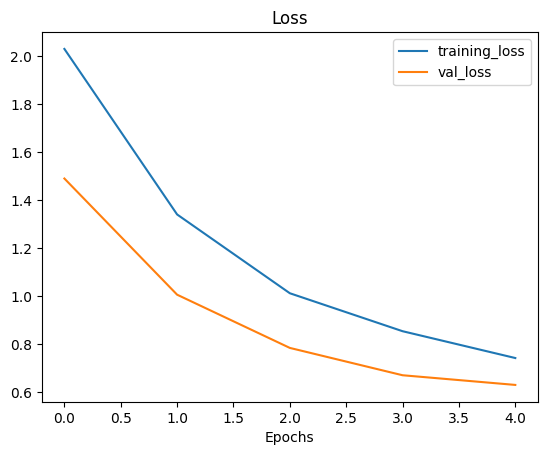

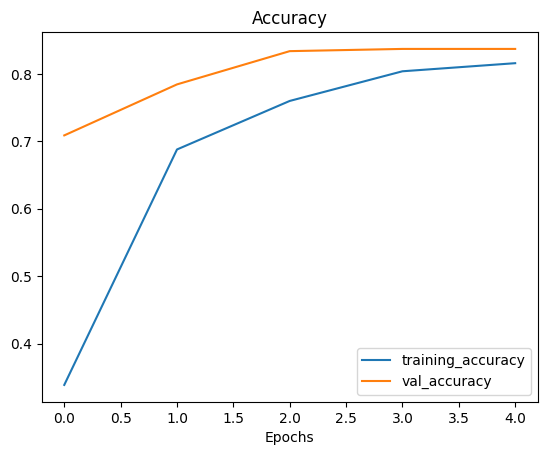

In [32]:
plot_loss_curves(history_10_percent_data_aug)

In [33]:
##Loading in checkpointed weights
#load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [34]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.6440 - accuracy: 0.8348


## Model 3: Fine-tuning an existing model on 10% of data.
Fine tuning usually best works after training of feature extraction model for a few epochs with large amounts of custom data.

In [35]:
#Layers in loaded model
model_2.layers

In [36]:
#Are these layers trainable.
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78c3d93bf7c0> True
<keras.src.engine.sequential.Sequential object at 0x78c45cb73340> True
<keras.src.engine.functional.Functional object at 0x78c3d8f47940> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x78c3dbb0d2d0> True
<keras.src.layers.core.dense.Dense object at 0x78c3d82f5ab0> True


In [37]:
#How many trainable variables are in our base model? its gonna be 0 since all are frozen.
print(len(model_2.layers[2].trainable_variables))

0


In [38]:
#To begin fine tuning lets start by setting the last 10 layers our base_model.trainable=True
#First unfreeze all layers
base_model.trainable=True

#Next freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

#Recompile (we have to recompile our model everytime we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #when fine-tuning you typically want to lower the learning rate by 10%
                metrics=['accuracy'])

In [39]:
#check which layers are tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [40]:
print(len(model_2.trainable_variables))

12


In [41]:
#Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240307-003517
Epoch 5/10
24/24 [==============================] - 29s 824ms/step - loss: 0.6239 - accuracy: 0.8293 - val_loss: 0.4721 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 13s 549ms/step - loss: 0.5254 - accuracy: 0.8507 - val_loss: 0.4513 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 19s 783ms/step - loss: 0.4579 - accuracy: 0.8667 - val_loss: 0.4304 - val_accuracy: 0.8651
Epoch 8/10
24/24 [==============================] - 13s 523ms/step - loss: 0.3951 - accuracy: 0.8747 - val_loss: 0.4157 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 15s 576ms/step - loss: 0.3402 - accuracy: 0.9040 - val_loss: 0.4134 - val_accuracy: 0.8651
Epoch 10/10
24/24 [==============================] - 13s 517ms/step - loss: 0.3303 - accuracy: 0.9080 - val_loss: 0.4313 - val_accuracy: 0.8651


In [42]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4299 - accuracy: 0.8628


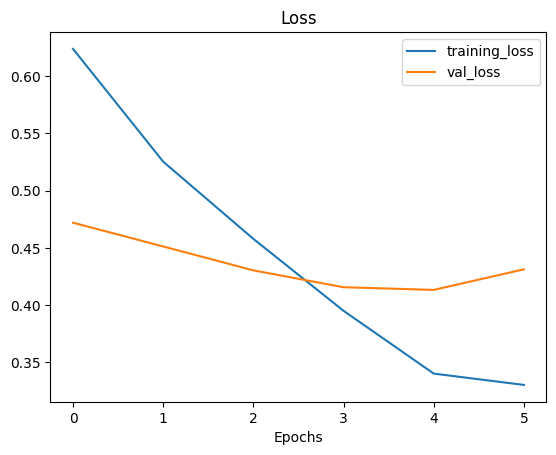

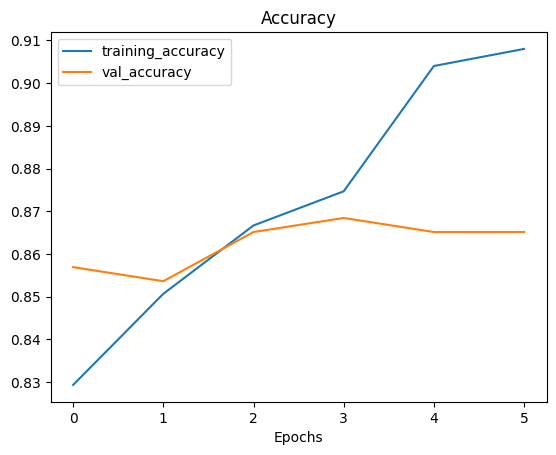

In [43]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot loss curves function` works great with models which has been fit once, however we want something to compare one series of running `fit()` with another(before and after fine-tuning).

In [50]:
#lets create a function for before and after fine tuning
def compare_historys(original_history, new_history, initial_epochs=5):

  #Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  #Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  #Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

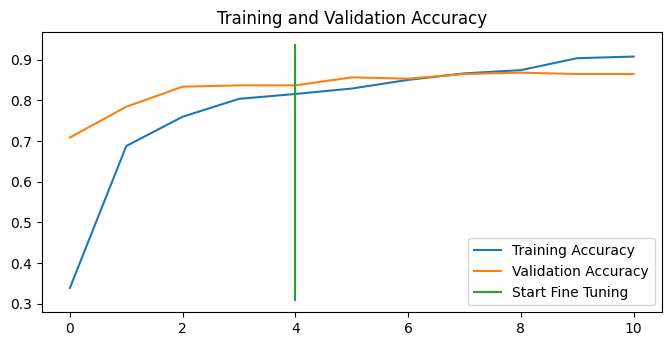

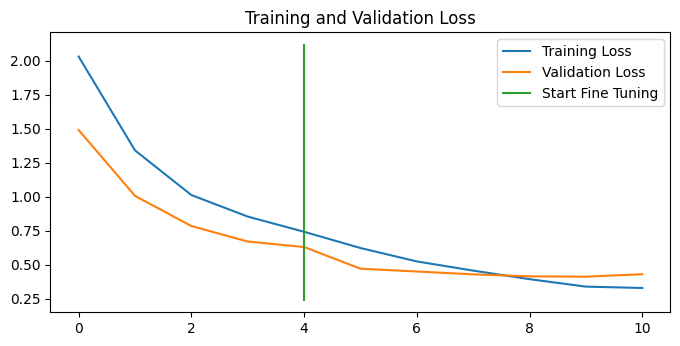

In [51]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)